In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s| data %.4f |grad %.4f }" % (n.label,n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

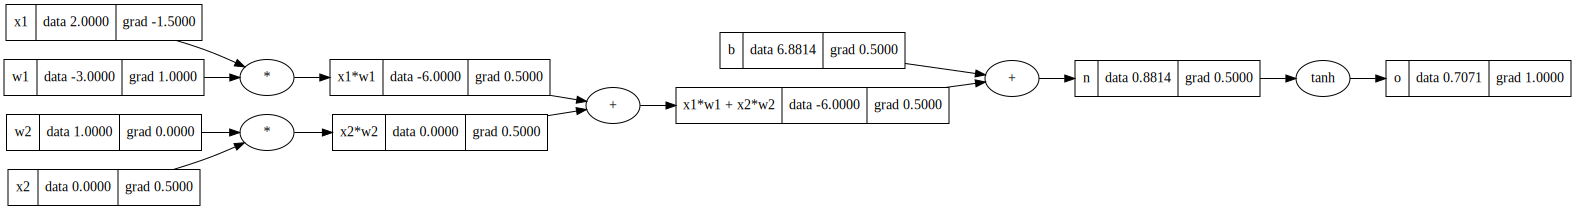

In [ ]:
draw_dot(o)


In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()


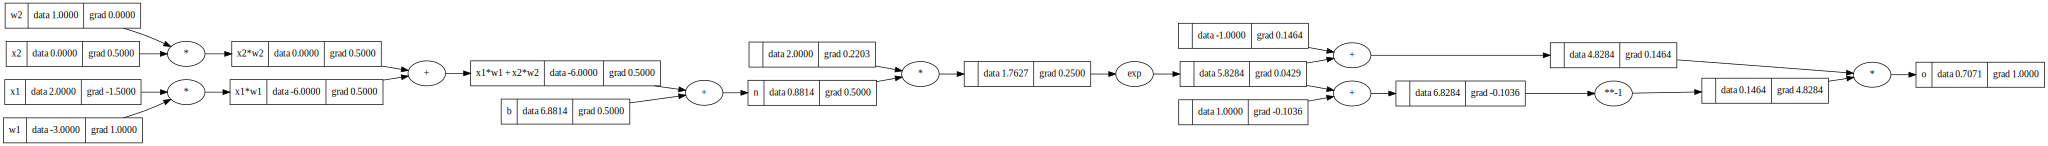

In [ ]:
draw_dot(o)

## DOing the same thing using pytorch

Micrograd is a scalar valued engine,like inputs are scalar values. But in pytorch, eveything is based on tensors.

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
o.item() #o.data.item()

0.7071066904050358

In [ ]:
x1.grad.item()

-1.5000003851533106

In [ ]:
from collections.abc import Sized

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x): #To enable n[x]
    # w * x + b
    # we would like to do a forward pass of this neuron
    # zip takes two iterators and it creates a new iterator that iterates over the tuples of the corresponding list
    # In other words it pairs the two pairs
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh() # tanh is the activation function
    return out
  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)


Value(data=0.624266907167052)

In [ ]:
len(n.parameters())

41

In [ ]:
n.parameters()

[Value(data=-0.11726468464679884),
 Value(data=-0.872511081179985),
 Value(data=-0.5321957287199304),
 Value(data=0.045789079158403245),
 Value(data=-0.47532023927083),
 Value(data=-0.038463907653634166),
 Value(data=-0.002445275725027729),
 Value(data=-0.3169271266431204),
 Value(data=0.795937730665524),
 Value(data=0.3038677278240205),
 Value(data=0.15365569470557494),
 Value(data=-0.5940883513076625),
 Value(data=0.05928232218630436),
 Value(data=-0.13370104249776826),
 Value(data=0.7890475933592505),
 Value(data=0.1254873205532403),
 Value(data=-0.6380138976181196),
 Value(data=0.9814624235679681),
 Value(data=0.7112507233317491),
 Value(data=0.352247141893655),
 Value(data=-0.7694762225975167),
 Value(data=-0.5695986810737748),
 Value(data=0.10882447431199749),
 Value(data=0.20380203241472183),
 Value(data=0.23074345548010133),
 Value(data=-0.6113074592534387),
 Value(data=0.9463865509892764),
 Value(data=0.6769652604225753),
 Value(data=0.66771608081667),
 Value(data=0.4851847887

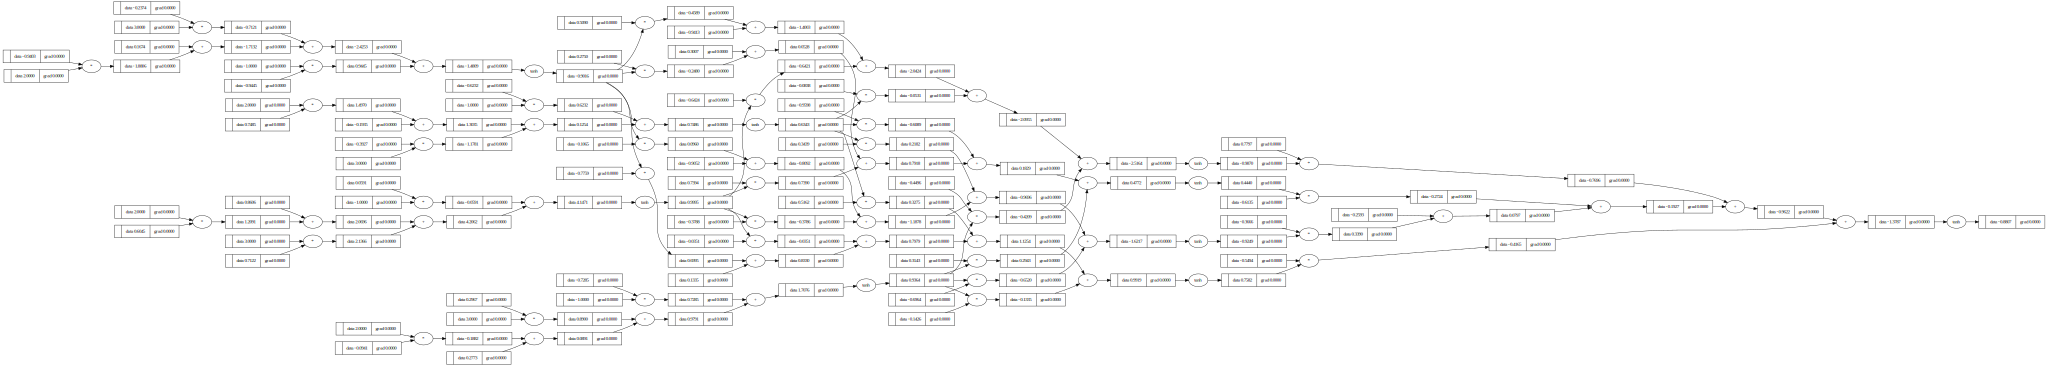

In [ ]:
draw_dot(n(x))

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.21679586962391462)

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Let get the neuron prediction
# forward pass
ypred = [n(x) for x in xs]
ypred

[Value(data=0.21679586962391462),
 Value(data=-0.3247441208339468),
 Value(data=-0.6289828572313922),
 Value(data=0.11420882560228823)]

WE have -0.88 and we want 1.o . We have -0.81 and we want -1 ....
To tune the weights to better have the desired output, is to calculate a single number that measures the total perfomance of the neural net. This number is called the Loss.

In [ ]:
# We will implemt the Mean squared Loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.9916589370555386)

We now want to minimise the loss . The greater the loss, the worse it is at predicting.

In [ ]:
# To calculate the backward propagation
loss.backward()

In [ ]:
 n.layers[0].neurons[0].w[0].grad

0.03080922411111159

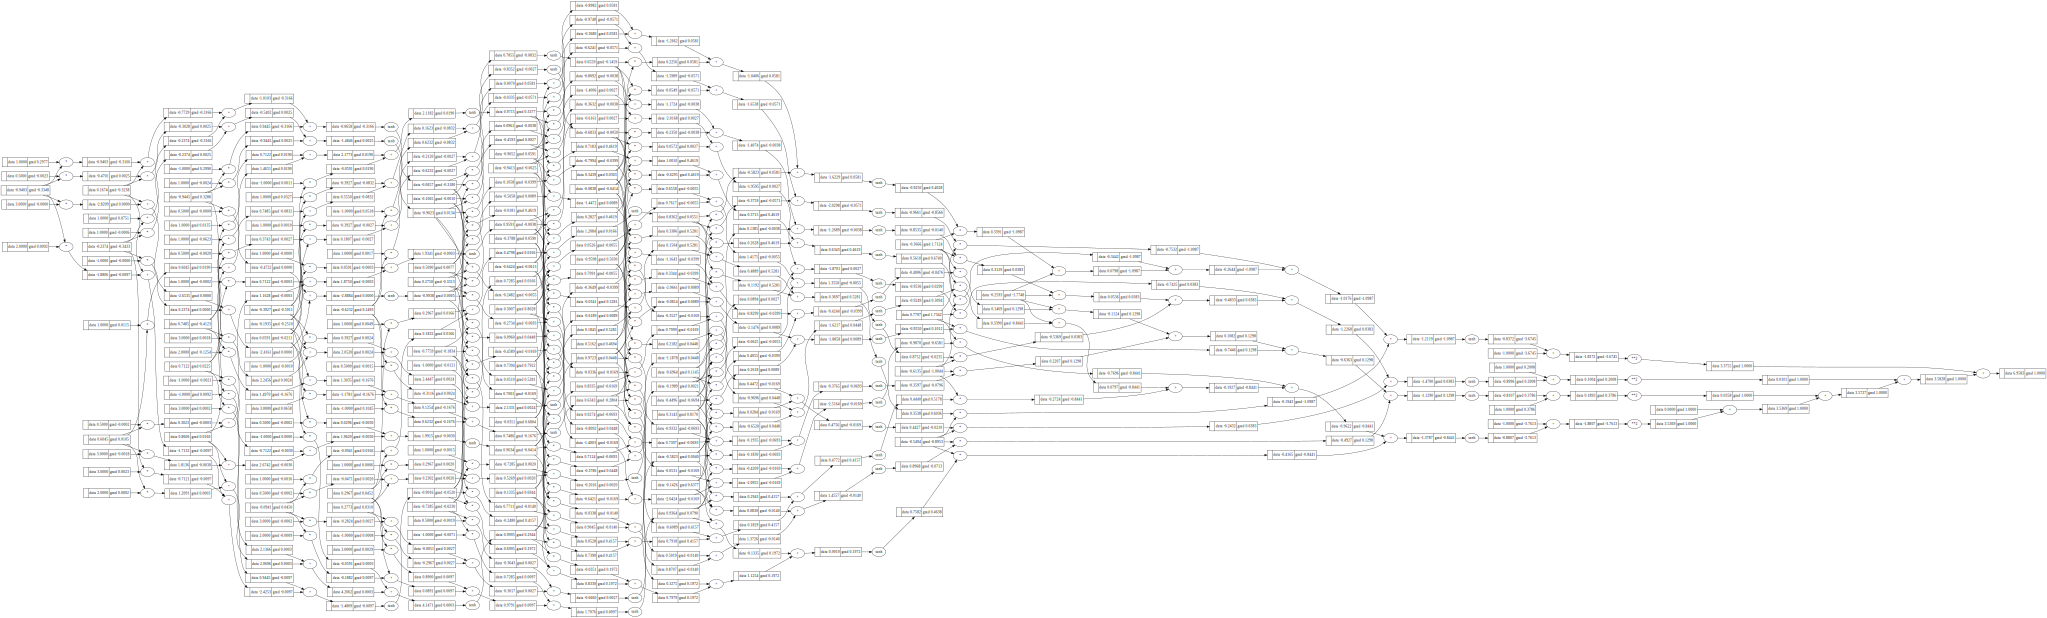

In [ ]:
draw_dot(loss)

In [ ]:
n.layers[0].neurons[0].w[0].data

-0.20688298197144528

In [ ]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
# We expect the loss to be a little lower
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.9916589370555386)

In short

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)


Value(data=-0.6018245762885684)

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]

  # Calc the loss
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # wE then do a backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # Then update or gradient discent
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)

0 0.010366630906734748
1 0.010338465182238892
2 0.010310447000335746
3 0.010282575222989513
4 0.010254848723725379
5 0.010227266387484328
6 0.010199827110479521
7 0.010172529800055456
8 0.010145373374548815
9 0.01011835676315152
10 0.010091478905775764
11 0.010064738752921258
12 0.010038135265543952
13 0.010011667414927376
14 0.00998533418255511
15 0.009959134559985847
16 0.009933067548729644
17 0.009907132160126637
18 0.009881327415226838
19 0.009855652344672134


In [ ]:
ypred

[Value(data=0.8476037621808373),
 Value(data=-0.819112687542266),
 Value(data=-0.8253209265011975),
 Value(data=0.8038230847432065)]